## AST 5371

Claudia Scarlata


### Mixture models

Mixture models arise when the overall population is the result of the superposition of distinct sub-populations.

One way to build a mixture model is to consider a finite weighted mixture of two or more distributions. This is known as a **finite mixture model**. The probability density of the observed data is the weighted sum of the probability densityfor *k* soubgroups of the data:

$$
p(y|\theta) = \sum_{i=1}^k w_ip_i(y|\theta_i) $$

where $w_i$ is the probability of the component *i*, so the values of $w_i$ are restricted to [0,1] and $\sum_{i=0}^kw_i = 1$. For finite mixture models, *k* is a finite value. 

We saw in class, how to estimate the parameters $\theta_i$, we introduce a *latent* random variable $z$, whose function is to specify from which component a particular observation is coming from. This variable is called latent because it is not directly observable.   

Using the same data used in class. The histogram below shows the distribution of (u-r) colors in a sample of galaxies selected in a small redshift slice (to ensure they are all approximately at the same distance).

### PyMC resources

[Official documentation](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Mixture.html)

[stackexchange](https://stats.stackexchange.com/questions/120028/2-gaussian-mixture-model-inference-with-mcmc-and-pymc)

[Plot_trace in depth](https://oriolabril.github.io/oriol_unraveled/python/arviz/matplotlib/2020/06/20/plot-trace.html)

Text(0.5, 0, 'Galaxy (u-r) color')

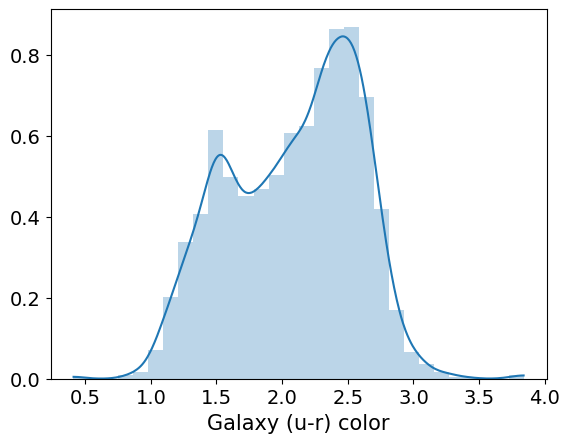

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats

data = pd.read_csv('/Users/claudia/Dropbox/5731/LABs/2021/W01/Assignment-01/ComaCluster_fluxes.csv')
# Apply cut for significant r detection
mask = (data['f_u']/data['fErr_u']>5)&(data['f_r']/data['fErr_r']>5)
umr = 2.5*np.log10(data['f_r'][mask]/data['f_u'][mask])
plt.show()
plt.hist(umr,bins=30,density = True,alpha = 0.3)
az.plot_kde(umr)
plt.xlabel('Galaxy (u-r) color',fontsize=15)



The bimodality in the distribution is clear, and the data cannot be properly described with a single Gaussian. We probably need two or three components, judging from the shape of the distribution. The solid line in the figure shows the KDE estimate of the probability density function.

We saw in class how we can develop an intuition of mixture models by generalizing the idea of "coin flipping". In this case we use a Bernoulli distribution to describe the outcome of flipping a coin, and a beta distribution on the prior of the probability of getting a head. 
In the mixture model we are in a similar situation, but now instead of two possible outcomes (H/T with probabilities $\theta$ and 1-$\theta$) we have *k* outcomes. The generalized Bernoulli distribution with *k* outcomes is the **categorical** distribution and the generalization of the Beta distribution is the **Dirichlet** distribution.


The ```Dirichlet``` distribution is defined in the n-dimensional [simplex](https://en.wikipedia.org/wiki/Simplex), basically an n-dimensional triangle. 
The output of this distribution is an n-dimensional vector, whose elements are restricted to be $\ge 0$, and sum up to 1. To get an idea of this distribution, look at the plots below, created with the code at [this link](https://gist.github.com/tboggs/8778945). 

<img src="dirichlet_plots.png" alt="Dirichlet plots" width="400"/>

A flat prior distribution on the simplex is obtained for $a=1$. Larger values of *a* result in more informative priors. 

To model the galaxy color distribution we will assume $k=3$. The statistical model is:

$$ y | z_i = k \sim N(\mu_k,\tau)$$
$$ \mu_k \stackrel{iid}{\sim} N_k(a,0.001)$$
$$ \tau \sim \text Gamma(0.5,0.5) $$
$$ w\sim \text Dir(\alpha) $$
$$ z_i|w_k \sim Cat(w)$$


and it can be implemented in PyMC3 as follows:

In [64]:
k=3
with pm.Model() as color_3mc:
    w = pm.Dirichlet('w',a=np.ones(k))
    z = pm.Categorical('z',p=w,shape=len(umr))
    means = pm.Normal('means',mu=umr.mean(),tau=1e-3,shape=k)
    tau = pm.Gamma('tau',alpha=0.5, beta=0.5)

    y = pm.Normal('y',mu = means[z], tau = tau,observed=umr)
    step1 = pm.Metropolis(vars=[w, tau, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[z])
    trace_color_mc= pm.sample(1000, step=[step1, step2],return_inferencedata=True)
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [w]
>>Metropolis: [tau]
>>Metropolis: [means]
>CategoricalGibbsMetropolis: [z]


/Users/claudia/anaconda3/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:296: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 596 seconds.


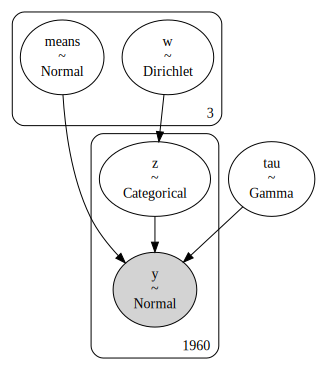

In [65]:
pm.model_to_graphviz(color_3mc)

array([[<AxesSubplot: title={'center': 'means'}>,
        <AxesSubplot: title={'center': 'means'}>],
       [<AxesSubplot: title={'center': 'w'}>,
        <AxesSubplot: title={'center': 'w'}>]], dtype=object)

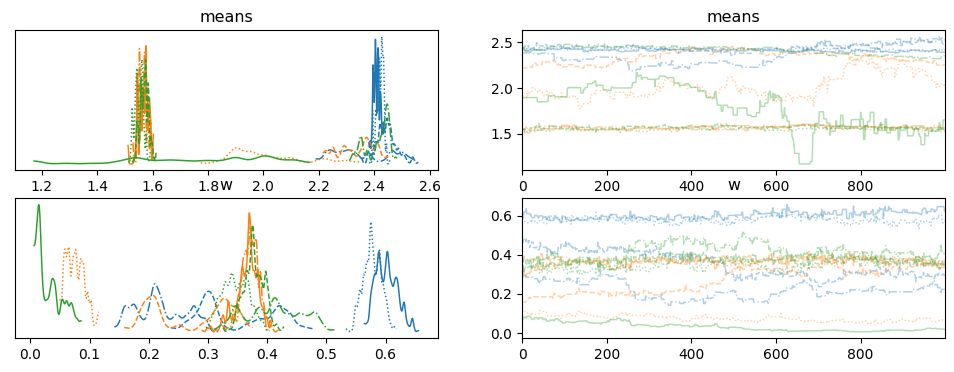

In [66]:
az.plot_trace(trace_color_mc,['means','w'])

In [68]:
az.summary(trace_color_mc,['means','w'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],2.408,0.063,2.245,2.513,0.023,0.017,8.0,26.0,1.57
means[1],1.871,0.333,1.533,2.391,0.163,0.124,5.0,17.0,2.27
means[2],1.829,0.369,1.525,2.455,0.180,0.139,5.0,13.0,2.34
w[0],0.438,0.164,0.169,0.623,0.081,0.062,5.0,17.0,2.72
w[1],0.271,0.125,0.056,0.389,0.061,0.047,5.0,15.0,2.24
w[2],0.292,0.154,0.006,0.451,0.075,0.058,5.0,12.0,2.07


There are two issues in the model specified above:
- we are tracking the latent variable *z*, making the code very slow. The way to solve this problem is to use the NormalMixture distrubution available in PyMC, which treats the *z* latent variable as a nuisance parameter.    
- we also did not add constraints on the order of the means, thus getting an example of the parameter non-identifiability phenomenon (or label-switching problem). The problem is that each chain is independent in tracking the *k* means and *w*. The sampler does not know which index label to assign to each component, and so across chains, the sampler is likely to assign different labels to the same cluster component. This problem is mitigated if you only use one chain (you can check that), but the problem is present also within one chain. We will solve this using Mixture in PyMC.   

In [133]:
k=3

with pm.Model() as mixture:
    w = pm.Dirichlet('w',a=np.ones(k))
    means = pm.Normal('means1',mu=[0.,1,2],tau=1e-3,shape=(3,))
    tau = pm.Gamma('tau',alpha=0.5, beta=0.5,shape=(3,))
    components = pm.Normal.dist(mu=means,tau=tau, shape=(3,))


    y = pm.Mixture('y', w=w, comp_dists=components, observed=umr)

    trace_out = pm.sample(5000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [w, means1, tau]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 132 seconds.


array([[<AxesSubplot: title={'center': 'means1'}>,
        <AxesSubplot: title={'center': 'means1'}>],
       [<AxesSubplot: title={'center': 'w'}>,
        <AxesSubplot: title={'center': 'w'}>],
       [<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

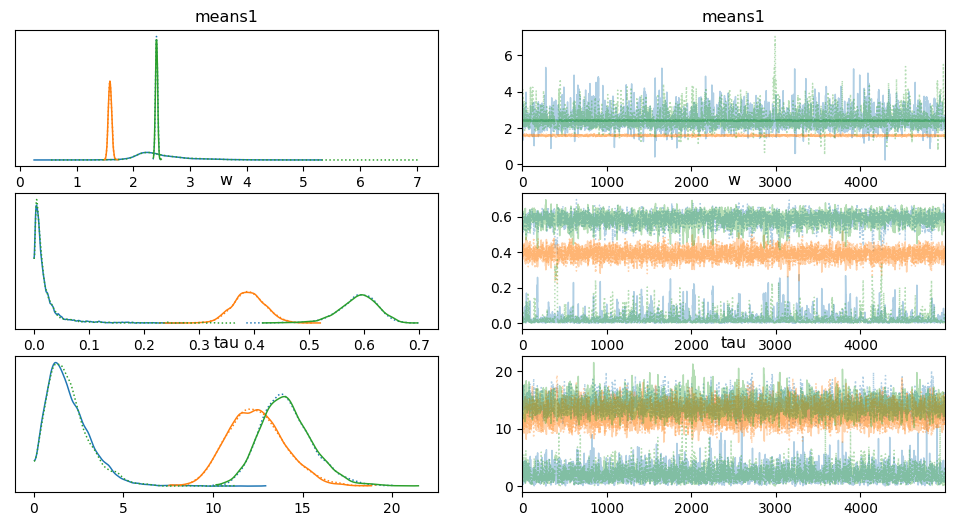

In [134]:
az.plot_trace(trace_out)

In [150]:
az.summary(trace_out)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means1[0],2.454,0.359,1.849,3.266,0.008,0.010,3079.0,45.0,1.64
means1[1],1.589,0.030,1.534,1.646,0.001,0.000,2288.0,2494.0,1.00
means1[2],2.458,0.375,1.871,3.223,0.012,0.010,2057.0,49.0,1.66
w[0],0.305,0.285,0.000,0.626,0.201,0.169,3.0,47.0,1.83
w[1],0.390,0.031,0.334,0.447,0.001,0.001,2303.0,2723.0,1.00
w[2],0.305,0.286,0.000,0.628,0.200,0.169,3.0,52.0,1.83
tau[0],8.043,6.207,0.170,15.880,4.304,3.616,3.0,57.0,1.83
tau[1],12.433,1.606,9.506,15.448,0.033,0.024,2416.0,2846.0,1.00
tau[2],8.035,6.226,0.149,15.897,4.317,3.626,3.0,54.0,1.83


In [136]:
trace_out

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot: title={'center': 'w\n0'}>,
        <AxesSubplot: title={'center': 'w\n0'}>],
       [<AxesSubplot: title={'center': 'w\n1'}>,
        <AxesSubplot: title={'center': 'w\n1'}>],
       [<AxesSubplot: title={'center': 'w\n2'}>,
        <AxesSubplot: title={'center': 'w\n2'}>]], dtype=object)

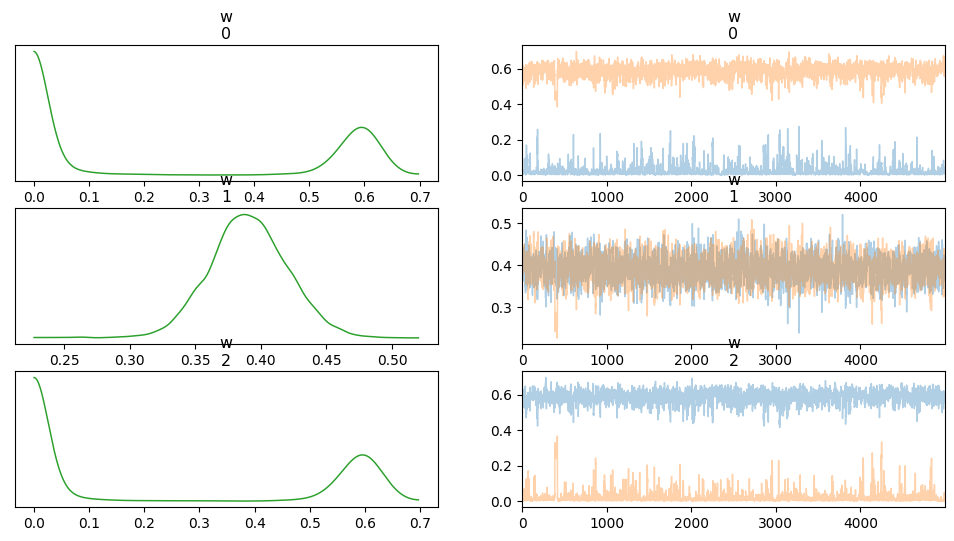

In [137]:
az.plot_trace(trace_out,['w'],combined=True,compact=False)

In [148]:
trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy().mean(1)
print(len(trace_out.posterior['means1'].to_numpy()))

2


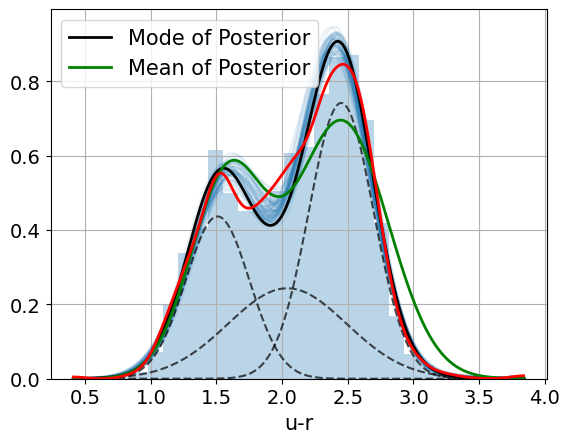

In [175]:
import random
from scipy import stats as st
x = np.linspace(umr.min(),umr.max(),200)

x_ = np.array([x]*3).T

for i in  range(50):
    i_ = np.random.randint(0,5000)
    means_y = trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    w_y = trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    tau_y = trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy()[:,i_]
    dist = stats.norm(means_y,1/np.sqrt(tau_y))
    plt.plot(x,np.sum(dist.pdf(x_)*w_y,1),'C0',alpha=0.1)


med_y = st.mode(trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()
medw_y = st.mode(trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()
medt_y = st.mode(trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy(),axis=1,keepdims=True)[0].flatten()

dist = stats.norm(med_y,1/np.sqrt(medt_y))
plt.plot(x,np.sum(dist.pdf(x_)*medw_y,1),'k',lw=2,label='Mode of Posterior')
plt.plot(x,dist.pdf(x_)*medw_y,'k--',alpha=0.7)

means_y = trace_out.posterior['means1'].stack(draws=("chain", "draw")).to_numpy().mean(1)
w_y = trace_out.posterior['w'].stack(draws=("chain", "draw")).to_numpy().mean(1)
tau_y = trace_out.posterior['tau'].stack(draws=("chain", "draw")).to_numpy().mean(1)
dist = stats.norm(means_y,1/np.sqrt(tau_y))
plt.plot(x,np.sum(dist.pdf(x_)*w_y,1),'g',lw=2,label='Mean of Posterior')





az.plot_kde(umr,plot_kwargs={'linewidth':2,'color':'r'})
plt.hist(umr,bins=30,density = True,alpha = 0.3)
plt.xlabel('u-r',fontsize=15)
plt.grid()
plt.legend(fontsize=15)



## Now an example of regression with outliers

In [122]:
data = pd.read_csv('Cepheids_DATA_errMVerrP.csv')
x = data['LogP']
y = data['MV']
err_x = data['LogP_err']
err_y = data['MV_err']

In [123]:

with pm.Model() as model_basic:
    beta_0 = pm.Normal('beta_0', 0, tau = 1e-3)
    beta_1 = pm.Normal('beta_1', 0, tau = 1e-3)
    tau = pm.Gamma('tau',0.5,0.5)

    y_obs = pm.Normal('y', mu=beta_0 + beta_1*x , sigma=tau, observed=y)

    trace_basic = pm.sample(1000, chains=4, cores=3, init='jitter+adapt_diag',return_inferencedata=True)
    
with pm.Model() as model_werr:

    beta_0 = pm.Normal('beta_0', 0, tau = 1e-3)
    beta_1 = pm.Normal('beta_1', 0, tau = 1e-3)
    tau = pm.Gamma('tau',0.5,0.5)
    x_ = pm.Data('features', x) # a data container, can be changed
    x_lat = pm.Normal('x_mu', mu=x,  sigma=err_x, shape=x.shape[0])
    x_obs = pm.Normal('x_obs', mu=0, sigma=1e3, observed=x_, shape=x.shape[0])
    y_pred = pm.Normal('y_pred', beta_0 + beta_1 * x_lat,tau=tau, shape=x.shape[0])
    y_obs = pm.Normal('y', mu=y_pred, sigma=err_y, observed=y)
   
    trace_werr = pm.sample(1000, chains=4, cores=3, init='jitter+adapt_diag',return_inferencedata=True)
    
with pm.Model() as model_outl:
    beta_0 = pm.Normal('beta_0', 0, tau = 1e-3)
    beta_1 = pm.Normal('beta_1', 0, tau = 1e-3)
    tau = pm.Gamma('tau',0.5,0.5)

    w = pm.Dirichlet('w', a=np.array([1, 1]))  # 2 mixture weights

    mu = beta_0 + beta_1*x
    components = [
        pm.Normal.dist(mu=mu, sigma=tau),
        pm.Uniform.dist(lower=-10, upper=10),
    ]

    y_obs = pm.Mixture('y', w=w, comp_dists=components, observed=y)
   
    trace_outl = pm.sample(1000, chains=4, cores=3, init='jitter+adapt_diag',return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [beta_0, beta_1, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
/Users/claudia/anaconda3/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [beta_0, beta_1, tau, x_mu, y_pred]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [beta_0, beta_1, tau, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [124]:
az.summary(trace_basic)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.486,0.184,-1.819,-1.131,0.005,0.003,1399.0,1837.0,1.00
beta_1,-2.595,0.215,-3.007,-2.201,0.006,0.004,1391.0,1915.0,1.00
tau,0.778,0.045,0.691,0.859,0.001,0.001,1839.0,1753.0,1.01


In [125]:
az.summary(trace_werr)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.750,0.143,-2.031,-1.488,0.002,0.001,4617.0,3011.0,1.0
beta_1,-2.308,0.166,-2.612,-1.996,0.002,0.002,4590.0,3379.0,1.0
x_mu[0],0.103,0.069,-0.018,0.239,0.001,0.001,8960.0,2900.0,1.0
x_mu[1],0.047,0.010,0.029,0.066,0.000,0.000,9787.0,2712.0,1.0
x_mu[2],0.417,0.020,0.378,0.453,0.000,0.000,7744.0,2992.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[158],-5.404,0.081,-5.555,-5.258,0.001,0.001,11350.0,2978.0,1.0
y_pred[159],-5.452,0.081,-5.604,-5.296,0.001,0.001,8716.0,2721.0,1.0
y_pred[160],-5.774,0.076,-5.923,-5.634,0.001,0.001,8450.0,3058.0,1.0
y_pred[161],-6.068,0.078,-6.209,-5.917,0.001,0.001,9281.0,3156.0,1.0


In [126]:
az.summary(trace_outl)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.958,0.113,-2.168,-1.745,0.002,0.002,2057.0,2156.0,1.0
beta_1,-2.114,0.131,-2.355,-1.865,0.003,0.002,2050.0,2330.0,1.0
tau,0.435,0.026,0.386,0.483,0.000,0.000,2854.0,2400.0,1.0
w[0],0.971,0.014,0.943,0.994,0.000,0.000,3323.0,2126.0,1.0
w[1],0.029,0.014,0.006,0.057,0.000,0.000,3323.0,2126.0,1.0


Text(0, 0.5, 'MV')

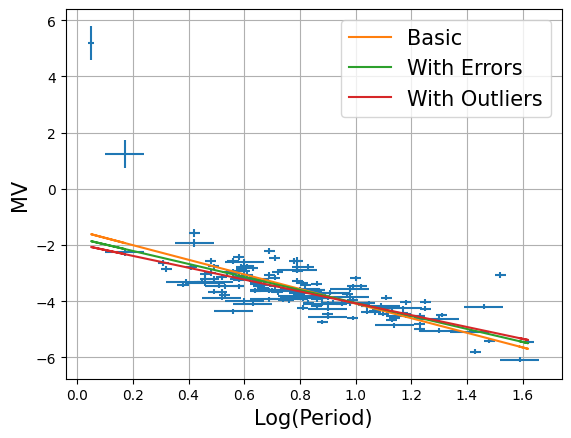

In [130]:
plt.errorbar(data['LogP'],data['MV'], yerr=data['MV_err'], xerr=data['LogP_err'], ls='none')
plt.plot(x,-2.599*x -1.484,label='Basic')
plt.plot(x,-2.313*x -1.747,label='With Errors')
plt.plot(x,-2.108*x -1.964,label='With Outliers')
plt.grid()
plt.legend(fontsize=15)
plt.xlabel('Log(Period)',fontsize=15)
plt.ylabel('MV',fontsize=15)